In [2]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import time

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./", one_hot=True)

learning_rate = 0.001
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [2]:
def conv_net(x, n_classes, dropout, reuse, is_training):
    with tf.variable_scope('ConvNet', reuse=reuse):
        x = tf.reshape(x, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, 64, 5, activation=tf.nn.relu)
        x = tf.layers.max_pooling2d(x, 2, 2)
        x = tf.layers.conv2d(x, 256, 3, activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 512, 3, activation=tf.nn.relu)
        x = tf.layers.max_pooling2d(x, 2, 2)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 2048)
        x = tf.layers.dropout(x, rate=dropout, training=is_training)
        x = tf.layers.dense(x, 1024)
        x = tf.layers.dropout(x, rate=dropout, training=is_training)
        out = tf.layers.dense(x, n_classes)
        out = tf.nn.softmax(out) if not is_training else out
    return out

In [3]:
def average_gradients(tower_grads):
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        grads = []
        for g, _ in grad_and_vars:
            expanded_g = tf.expand_dims(g, 0)
            grads.append(expanded_g)
        grad = tf.concat(grads, 0)
        grad = tf.reduce_mean(grad, 0)
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

In [4]:
PS_OPS = ['Variable', 'VariableV2', 'AutoReloadVariable']
def assign_to_device(device, ps_device='/cpu:0'):
    def _assign(op):
        node_def = op if isinstance(op, tf.NodeDef) else op.node_def
        if node_def.op in PS_OPS:
            return "/" + ps_device
        else:
            return device
    return _assign

In [66]:
num_steps = 160
batch_size = 4*1024
display_step = 80
gpus=[1,2,3,4]
t=[]
for num_gpus in gpus:
    tf.reset_default_graph()
    print("Training with %i GPUs" % num_gpus)
    with tf.device('/cpu:0'):
        tower_grads = []
        reuse_vars = False
        X = tf.placeholder(tf.float32, [None, num_input])
        Y = tf.placeholder(tf.float32, [None, num_classes])
        for i in range(num_gpus):
            with tf.device(assign_to_device('/gpu:{}'.format(i), ps_device='/cpu:0')):
                _x = X[i * batch_size: (i+1) * batch_size]
                _y = Y[i * batch_size: (i+1) * batch_size]
                logits_train = conv_net(_x, num_classes, dropout,reuse=reuse_vars, is_training=True)
                logits_test = conv_net(_x, num_classes, dropout,reuse=True, is_training=False)
                loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                    logits=logits_train, labels=_y))
                optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
                grads = optimizer.compute_gradients(loss_op)
                if i == 0:
                    correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.argmax(_y, 1))
                    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
                reuse_vars = True
                tower_grads.append(grads)
        tower_grads = average_gradients(tower_grads)
        train_op = optimizer.apply_gradients(tower_grads)
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            step = 1
            ts = time.time()
            for step in range(1, num_steps + 1):
                batch_x, batch_y = mnist.train.next_batch(batch_size * num_gpus)
                sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
                if step % display_step == 0 or step == 1:
                    loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,Y: batch_y})
                    print("Step " + str(step) + ", Training Accuracy= " + "{:.3f}".format(acc)) 
                step += 1
        t.append((time.time() - ts)*10*mnist.train.num_examples/(batch_x.shape[0]*num_steps))
        print("Expected Training time for 10 epoches is %.2f seconds with %d GPUs"%(t[-1],num_gpus))
                        

Training with 1 GPUs
Step 1, Training Accuracy= 0.165
Step 80, Training Accuracy= 0.993
Step 160, Training Accuracy= 0.998
Expected Training time for 10 epoches is 64.75 seconds with 1 GPUs
Training with 2 GPUs
Step 1, Training Accuracy= 0.458
Step 80, Training Accuracy= 0.995
Step 160, Training Accuracy= 0.999
Expected Training time for 10 epoches is 57.49 seconds with 2 GPUs
Training with 3 GPUs
Step 1, Training Accuracy= 0.290
Step 80, Training Accuracy= 0.996
Step 160, Training Accuracy= 1.000
Expected Training time for 10 epoches is 52.17 seconds with 3 GPUs
Training with 4 GPUs
Step 1, Training Accuracy= 0.259
Step 80, Training Accuracy= 0.996
Step 160, Training Accuracy= 1.000
Expected Training time for 10 epoches is 49.59 seconds with 4 GPUs


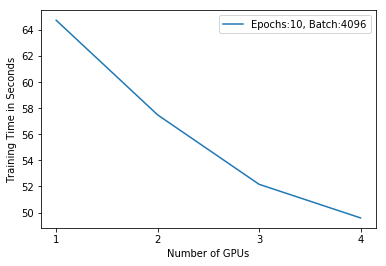

In [68]:
import matplotlib.pyplot as plt
plt.plot(gpus, t, label='Epochs:10, Batch:%d' % batch_size)
plt.xlabel("Number of GPUs")
plt.ylabel("Training Time in Seconds")
plt.xticks(np.arange(1,5, 1))
plt.legend()
plt.show()